# Assignment-1 Bandits and Exploration or Exploitation

This notebook uses RL-Glue to implement most of the experiments. This library will give a solid framework to understand how reinforcement learning experiments work and how to run our own. 

We might have noticed that we import ten_arm_env. This is the __10-armed Testbed__ introduced in [section 2.3](http://www.incompleteideas.net/book/RLbook2018.pdf) of the textbook. We use this throughout this notebook to test our bandit agents. It has 10 arms, which are the actions the agent can take. Pulling an arm generates a stochastic reward from a Gaussian distribution with unit-variance. For each action, the expected value of that action is randomly sampled from a normal distribution, at the start of each run.

### When complete this assignment, we will learn about:
- the ***effect of epsilon, an exploration parameter***, on the performance of an agent
- the ***effect of step size*** on the performance of the agent
- a good experiment ***practice of averaging across multiple runs***

Remark: Stationarity Environment - means that the environment will not change over time


### Table of Content
- 0. Preliminaries
- 1. Greedy Agent
- 2. Epsilon-Greedy Agent
- 3. Compare Epsilon Greedy Agent against Greedy Agent with Epsilon of 0.1
     - 3.1 Averaging Multiple Runs
- 4. Comparing values of epsilon
- 5. The Effect of Step Size

# 0. Preliminaries

In [1]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rl_glue import RLGlue
import rl_glue
import main_agent
import ten_arm_env

# 1. Greedy Agent

We want to ***create an agent that will find the action with the highest expected reward***. One way an agent could operate is to ***always choose the action with the highest value based on the agent’s current estimates***. This is called a ***greedy agent*** as it greedily chooses the action that it thinks has the highest value. 

First we are going to ***implement the argmax function***, which ***takes in a list of action values and returns an action with the highest value***. 

Why are we implementing our own instead of using the argmax function that numpy uses? 
- Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as ***it biases the agent to choose a specific action in the case of ties***. Instead we want to ***break ties between the highest values randomly***. So we are going to implement our own argmax function.

In [2]:
# use argmax function to take in a list of q_values and returns the index of the item with the highest value - breaks ties randomly
def argmax(q_values):                         

    top_value = float("-inf")                 # initial top_value equal to negative infinity
    
    ties = []                                 # create an empty ties list
    
    for i in range(len(q_values)):            # loop over each of q_values
                
        if q_values[i] > top_value:           # if q_values is greater than the highest value
            
            top_value = q_values[i]           # update top_value = q_values
            
            ties=[i]                          # reset ties to i
        
        elif q_values[i] == top_value:        # if q_values equal to top value 

            ties.append(i)                    # add the index to ties
    
    return np.random.choice(ties)             # return a random selection from list of ties

Now we introduce the first part of an RL-Glue agent that we will implement. Here we are going to create a GreedyAgent and implement the agent_step method: 
- This method gets called each time the agent takes a step. 
- The method has to return the action selected by the agent. 
- This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.

In [3]:
class GreedyAgent(main_agent.Agent):
    
    # Takes one step for the agent it takes in a reward and observation, and returns the action the agent chooses at that time step.
    def agent_step(self, reward, observation = None):
        
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        self.arm_count[self.last_action] += 1       # increment the counter in self.arm_count for the action 
                                                     # from the previous time step 
            
            
        # self.q_values : An array with what the agent believes each of the values of the arm are
        # update self.q_values for the action from the previous time step
        self.q_values[self.last_action] = self.q_values[self.last_action] + (1 / self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])
            
        current_action = argmax(self.q_values)      # chosen highest value of the possible actions estimated by the agent
        
        
        # self.last_action : The action that the agent took on the previous time step
        self.last_action = current_action
        
        
        return current_action                       # the action chosen by the agent at the current time step

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 71.55it/s]


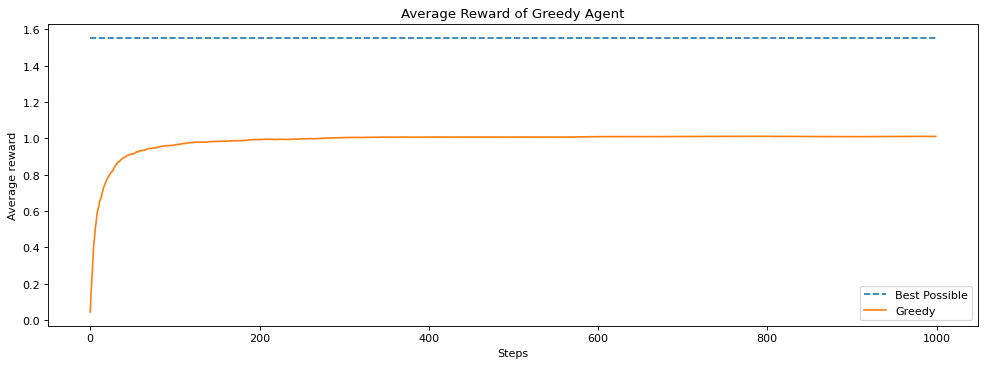

In [4]:
# Let's visualize the result. Here we run an experiment using RL-Glue to test our agent.

num_runs = 200                            # The number of times we run the experiment
num_steps = 1000                          # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment             # set what environment we want to use to test
agent = GreedyAgent                       # choose what agent we want to use
agent_info = {"num_actions": 10}          # pass the agent the information it needs. Here how many arms there are.
env_info = {}                             # pass the environment the information it needs. In this case nothing.

Greedy_all_averages = []                         # create list of all_averages

Greedy_average_best = 0                          # initialize average_best = 0

for run in tqdm(range(num_runs)):         # tqdm is what creates the progress bar below
    
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above    
    rl_glue.rl_init(agent_info, env_info) # pass RLGlue what it needs to initialize the agent and environment  
    rl_glue.rl_start()                    # start the experiment

    
    Greedy_average_best += np.max(rl_glue.environment.arms)  # update average_best
    
    Greedy_scores = [0]                               # initialize list of scores starting with 0
    
    Greedy_averages = []                              # initialize empty list of averages 
    
    
    for i in range(num_steps):                        # loop over each number of steps
        
        reward, _, action, _ = rl_glue.rl_step()      # The environment and agent take a step and return reward, and action taken.
        
        Greedy_scores.append(Greedy_scores[-1] + reward)            # update list of scores, sum up latest scores and new reward received 
        
        Greedy_averages.append(Greedy_scores[-1] / (i + 1))         # update list of averages, take average with the lastest updated scores
     
    
    Greedy_all_averages.append(Greedy_averages)         # update list of all_averages per each run

# plot the figures
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([Greedy_average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(Greedy_all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

#greedy_scores = np.mean(all_averages, axis=0)

# 2. Epsilon-Greedy Agent

Another way for an agent to operate, it ***does not always take the greedy action***. Instead, sometimes it ***takes an exploratory action***. It does this so that it can ***find out what the best action really is***. If we always choose what we think is the current best action is, we may miss out on taking the true best action, because we haven't explored enough times to find that best action.

In [5]:
# Takes one step for the agent. It takes in a reward and observation and returns the action the agent chooses at that time step.
class EpsilonGreedyAgent(main_agent.Agent):
    
    def agent_step(self, reward, observation):
        
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        self.arm_count[self.last_action] += 1       # increment the counter in self.arm_count for the action 
                                                     # from the previous time step 
            
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # update self.q_values for the action from the previous time step
        self.q_values[self.last_action] = self.q_values[self.last_action] + (1 / self.arm_count[self.last_action]) * (reward - self.q_values[self.last_action])
           
            
        # Choose action using epsilon greedy        
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        if np.random.random(size=None) < self.epsilon:              # Randomly choose a number between 0 and 1 and see if it's less than self.epsilon 
                                                                    
            current_action = np.random.randint(0,self.num_actions)  # chosen current_action to a random action
        
        else:                                                       
        
            current_action = argmax(self.q_values)                  # otherwise choose current_action greedily
        
        # self.last_action : The action that the agent took on the previous time step
        self.last_action = current_action
        
        return current_action

# 3. Compare Epsilon Greedy Agent against Greedy Agent with Epsilon 0.1

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 71.78it/s]


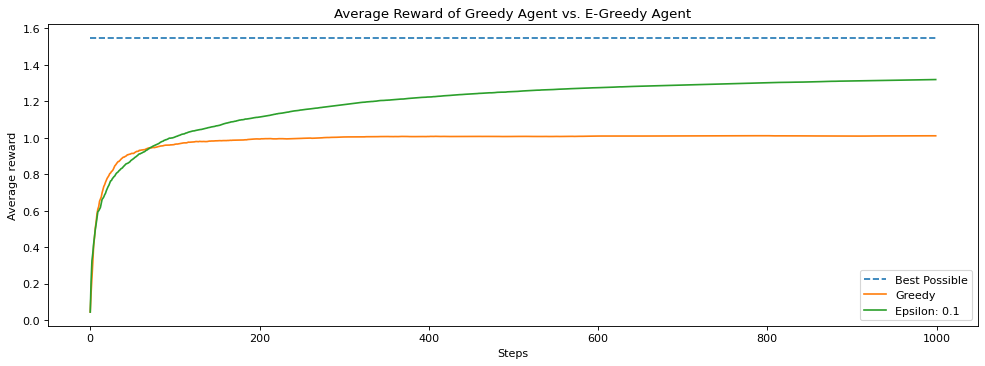

In [6]:
# Plot Epsilon greedy results and greedy results
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
EpsilonGreedy_all_averages = []

for run in tqdm(range(num_runs)):
    
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    EpsilonGreedy_scores = [0]
    
    EpsilonGreedy_averages = []
    
    for i in range(num_steps):
        
        reward, _, action, _ = rl_glue.rl_step()       # The environment and agent take a step and return reward, and action taken.
        
        EpsilonGreedy_scores.append(EpsilonGreedy_scores[-1] + reward)
        
        EpsilonGreedy_averages.append(EpsilonGreedy_scores[-1] / (i + 1))
        
    EpsilonGreedy_all_averages.append(EpsilonGreedy_averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")            # plot best possible

plt.plot(np.mean(Greedy_all_averages, axis=0))                        # plot greedy scores

plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")

plt.plot(np.mean(EpsilonGreedy_all_averages, axis=0))                 # plot epsilon greed scores

plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

***Remark:***
- Notice how much better the epsilon-greedy agent did. Because we occasionally choose a random action we were able to find a better long term policy. ***By acting greedily before our value estimates are accurate, we risk settling on a suboptimal action***.

# 3.1 Averaging Multiple Runs

Did you notice that we averaged over 200 runs? Why did we do that?

To get some insight, let's look at the results of two individual runs by the same agent.

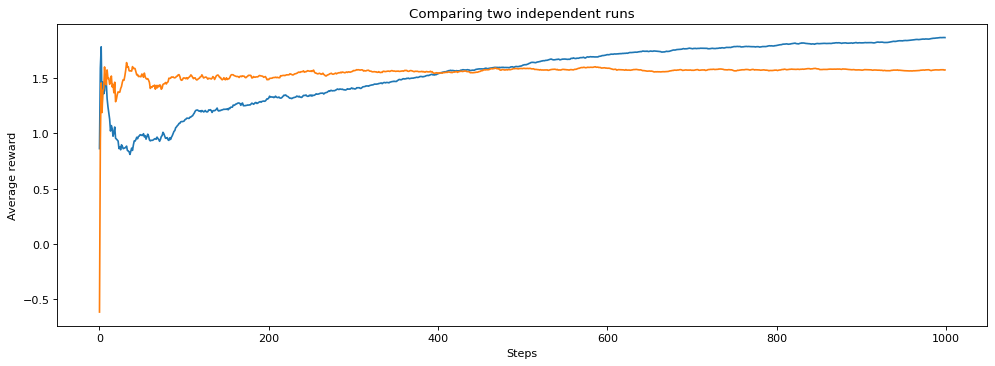

In [7]:
# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
EpsilonGreedy_all_averages = []

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    
    np.random.seed(run)                       # Here we set the seed so that we can compare two different runs
    
    EpsilonGreedy_averages = []
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    EpsilonGreedy_scores = [0]
    
    for i in range(num_steps):
        
        reward, state, action, is_terminal = rl_glue.rl_step()
        
        EpsilonGreedy_scores.append(EpsilonGreedy_scores[-1] + reward)
        
        EpsilonGreedy_averages.append(EpsilonGreedy_scores[-1] / (i + 1))
    
    plt.plot(EpsilonGreedy_averages)

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Notice how the two runs were different? But, ***if this is the exact same algorithm, why does it behave differently in these two runs?***

The answer is that:
- it is ***due to randomness in the environment and in the agent***. 
- ***Depending on what action the agent randomly starts with***, or 
- ***when it randomly chooses to explore***

It can change the results of the runs. And even if the agent chooses the same action, ***the reward from the environment is randomly sampled from a Gaussian***:
- The agent ***could get lucky***, and ***see larger rewards for the best action early on*** and so ***settle on the best action faster***. or
- It ***could get unlucky*** and ***see smaller rewards for best action early on*** and so ***take longer to recognize that it is in fact the best action***.

To be more concrete, let’s look at how many times an exploratory action is taken, for different seeds. 

In [8]:
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")
    

print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action


Random Seed 2
Exploratory Action


With the ***first seed***, we ***take an exploratory action three times out of 15***, but with ***the second***, we only ***take an exploratory action once***. 

This can ***significantly affect the performance of our agent*** because the amount of exploration has changed significantly.

To compare algorithms, we therefore report performance averaged across many runs. 

We do this to ensure that we are not simply reporting a result that is due to stochasticity. Rather, we want statistically significant outcomes. We will not use statistical significance tests. Instead, because we have access to simulators for our experiments, we use the simpler strategy of running for a large number of runs and ensuring that the confidence intervals do not overlap. 

# 4. Comparing Values of Epsilon

Can we do better than an epsilon of 0.1? Let's ***try several different values for epsilon*** and see how they perform. Below we run an experiment where we sweep over different values for epsilon:

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 90.58it/s]


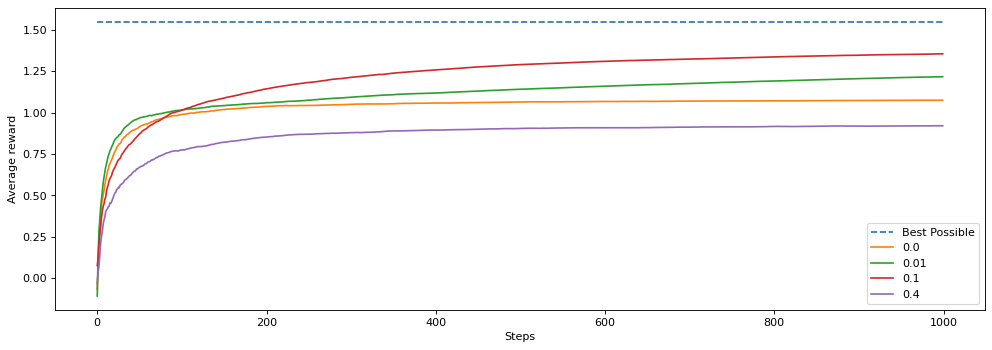

In [9]:
# Experiment code for different e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Remark:
- Why did 0.1 perform better than 0.01?
- If exploration helps why did 0.4 perform worse that 0.0 (the greedy agent)?

# 5. The Effect of Step Size

In Section 1 of this assignment, we decayed the step size over time based on action-selection counts. The step-size was 1/N(A), where N(A) is the number of times action A was selected. This is the same as computing a sample average. 

We could also set the step size to be a constant value, such as 0.1. What would be the effect of doing that? And is it better to use a constant or the sample average method? 

To investigate this question, let’s start by ***creating a new agent that has a constant step size***. 

This will be nearly identical to the agent created above. We will ***use the same code to select the epsilon-greedy action***. We will change the update to have a constant step size instead of using the 1/N(A) update.

In [10]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    
    # Takes one step for the agent. It takes in a reward and observation and returns the action the agent chooses at that time step.
    def agent_step(self, reward, observation):
       
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        self.arm_count[self.last_action] += 1                       # increment the counter in self.arm_count for the action from the previous time step 
            
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # update self.q_values for the action from the previous time step
        # apply constant step size
        self.q_values[self.last_action] = self.q_values[self.last_action] + (self.step_size) * (reward - self.q_values[self.last_action])
        
        # Choose action using epsilon greedy        
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        if np.random.random(size=None) < self.epsilon:              # Randomly choose a number between 0 and 1 and
                                                                    # see if it's less than self.epsilon 
                                                                    
            current_action = np.random.randint(0,self.num_actions)  # chosen current_action to a random action
        
        else:
        
            current_action = argmax(self.q_values)                  # otherwise choose current_action greedily
        
        # self.last_action : The action that the agent took on the previous time step
        self.last_action = current_action
        
        return current_action

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 76.68it/s]
/var/folders/vs/qjltbn7d2437nc29s6lk_cvw0000gn/T/ipykernel_4774/2121372653.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


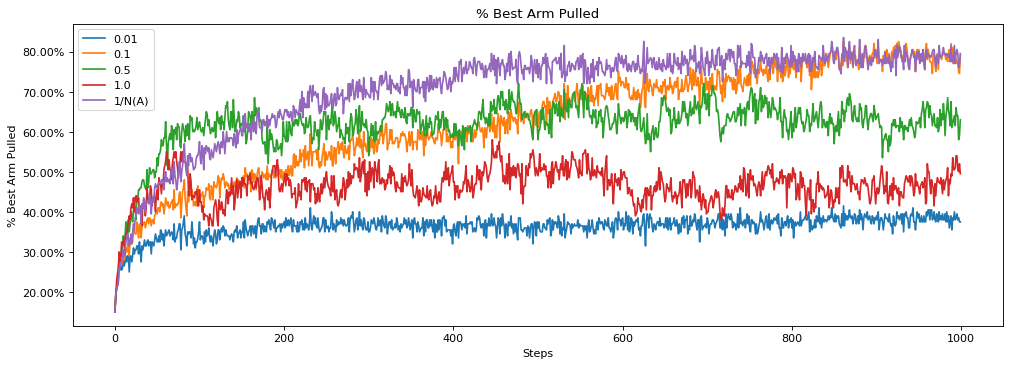

In [11]:
# Experiment code for different step sizes
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Notice first that we are now plotting the amount of time that ***the best action is taken rather than the average reward***. 

***To better understand the performance of an agent***, it can be useful to ***measure specific behaviors***, beyond just how much reward is accumulated. ***This measure indicates how close the agent’s behaviour is to optimal***.

It seems as though ***1/N(A) performed better than the others***, in that it reaches a solution where it takes the best action most frequently. 

Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?

Let's dig into this further below. Let’s plot how well each agent tracks the true value, where each agent has a different step size method.

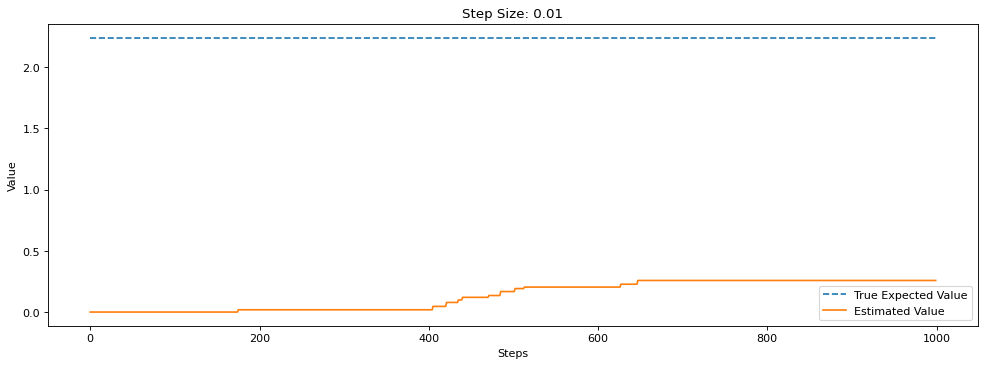

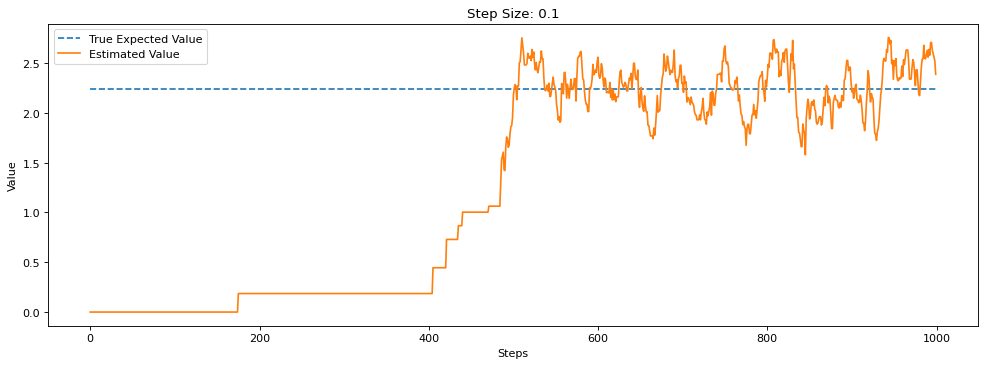

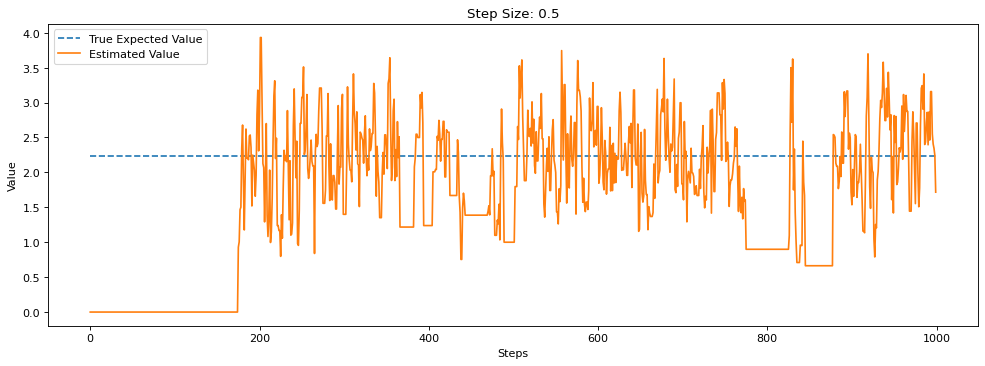

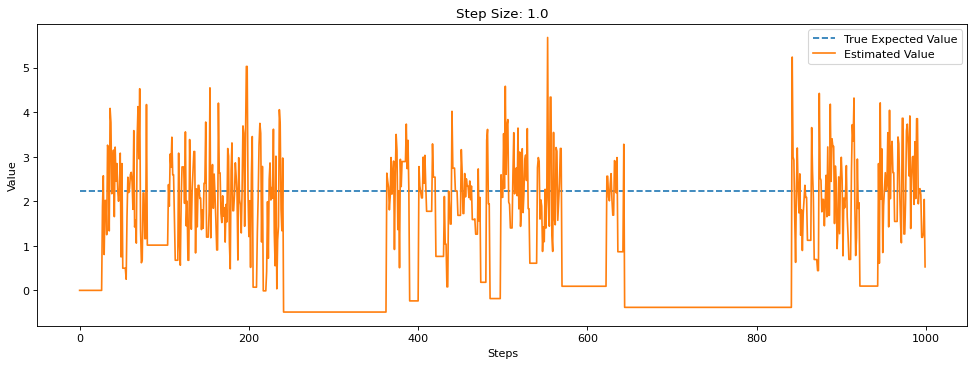

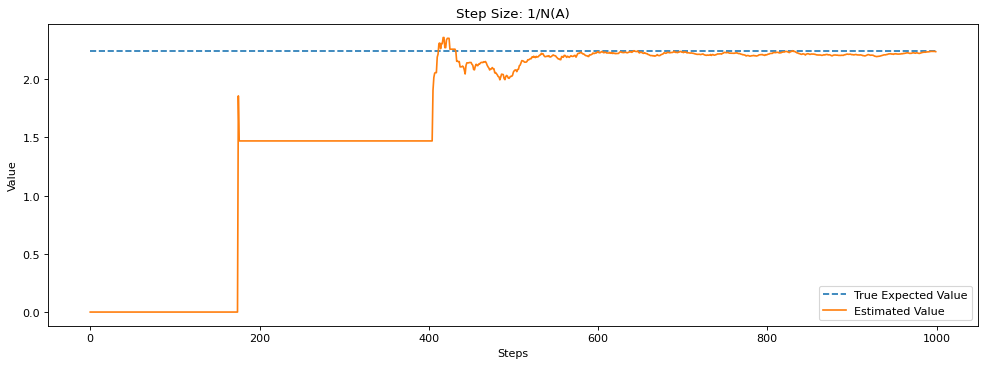

In [12]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

These plots help clarify the ***performance differences between the different step sizes***. 

A step size of 0.01:
- makes such small updates that ***the agent’s value estimate of the best action does not get close to the actual value***. 

Step sizes of 0.5 and 1.0:
- both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. 
- ***The updates overcorrect too much towards recent rewards***, and so oscillate around the true value. 
- This means that on many steps, ***the action that pulls the best arm may seem worse than it actually is***.

A step size of 0.1:
- ***updates fairly quickly to the true value***, and **does not oscillate as widely around the true values*** as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. 

***Finally we see why 1/N(A)***:
- performed well early on while the step size is still reasonably high ***it moves quickly to the true expected value***
- but as it gets pulled more its step size is reduced which makes ***it less susceptible to the stochasticity of the rewards***.

Does this mean that 1/N(A) is always the best? ***When might it not be?***
- One possible setting where it might not be as effective is in ***non-stationary problems***. 

***Non-stationarity*** means that ***the environment may change over time***. 
- This could manifest itself as continual change over time of the environment, or a sudden change in the environment.

Let's look at how a sudden change in the reward distributions affects a step size like 1/N(A). 

This time we will run the environment for 2000 steps, and after 1000 steps we will randomly change the expected value of all of the arms.

We compare two agents, both using epsilon-greedy with epsilon = 0.1. One uses a constant step size of 0.1, the other a step size of 1/N(A) that reduces over time. 

100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 38.22it/s]


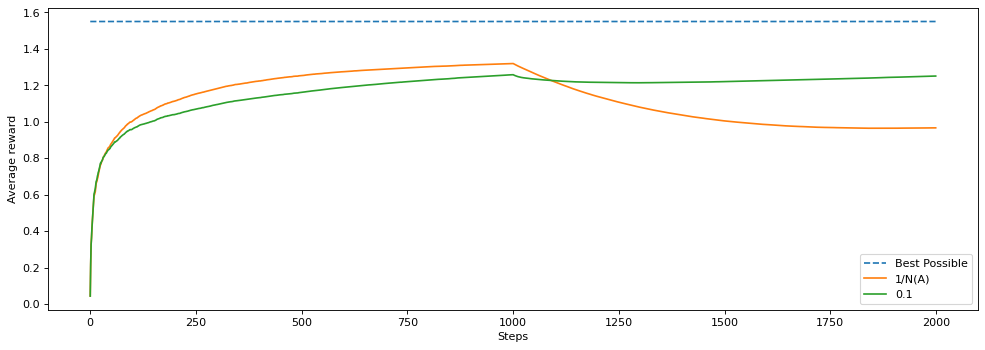

In [13]:
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Now the agent with a step size of 1/N(A) performed better at the start but then performed worse when the environment changed! What happened?

Think about what ***the step size would be after 1000 steps***. Let's say ***the best action gets chosen 500 times***. That means ***the step size for that action is 1/500 or 0.002***. At each step when we ***update the value of the action and the value is going to move only 0.002*** * the error. ***That is a very tiny adjustment*** and it will take a long time for it to get to the true value.

***The agent with step size 0.1***, however, will always update in 1/10th of the direction of the error. This means that ***on average it will take ten steps for it to update its value to the sample mean***.

### These are the types of tradeoffs we have to think about in reinforcement learning:
- ***A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value***. 

- A ***step size that reduces over time can converge to close to the expected value***, without oscillating. 

- On the other hand, ***such a decaying stepsize is not able to adapt to changes in the environment***. 

- ***Nonstationarity***---and the related concept of partial observability---is a common feature of reinforcement learning problems and when learning online.  

***End of Page***